## Load in Serialized values

In [1]:
import pickle 
import pandas as pd
import json

inp_data = pd.read_csv('serialize/inp_data.csv')

with open('serialize/x.pickle', 'rb') as out:
    x = pickle.load(out)

with open('serialize/x_2g.pickle', 'rb') as out:
    x_2g = pickle.load( out)

with open('serialize/normalized_x.pickle', 'rb') as out:
    normalized_x = pickle.load(out)

with open('serialize/normalized_x2g.pickle', 'rb') as out:
    normalized_x2g = pickle.load(out)

with open('serialize/vocabulary.json', 'r') as out:
    cv_vocabulary_ = json.load(out)
    
with open('serialize/vocabulary_2g.json', 'r') as out:
    cv_2grams_vocabulary_ = json.load(out)

## Collect keywords for each city using TFIDF

In [2]:
normalized_x.shape

(317, 5615)

In [3]:
print(inp_data.shape)

(317, 8)


In [4]:
from wordcloud import WordCloud
help(WordCloud)

Help on class WordCloud in module wordcloud.wordcloud:

class WordCloud(builtins.object)
 |  WordCloud(font_path=None, width=400, height=200, margin=2, ranks_only=None, prefer_horizontal=0.9, mask=None, scale=1, color_func=None, max_words=200, min_font_size=4, stopwords=None, random_state=None, background_color='black', max_font_size=None, font_step=1, mode='RGB', relative_scaling='auto', regexp=None, collocations=True, colormap=None, normalize_plurals=True, contour_width=0, contour_color='black', repeat=False, include_numbers=False, min_word_length=0, collocation_threshold=30)
 |  
 |  Word cloud object for generating and drawing.
 |  
 |  Parameters
 |  ----------
 |  font_path : string
 |      Font path to the font that will be used (OTF or TTF).
 |      Defaults to DroidSansMono path on a Linux machine. If you are on
 |      another OS or don't have this font, you need to adjust this path.
 |  
 |  width : int (default=400)
 |      Width of the canvas.
 |  
 |  height : int (defaul

In [5]:
import matplotlib.pyplot as plt

terms = sorted(list(cv_2grams_vocabulary_.keys()))
city_specific_keywords = dict()
for i, (city) in enumerate(inp_data['city_name']):
    row = normalized_x2g[i, :].toarray()[0]
    top_feats = list(sorted(enumerate(row), key=lambda t: t[1], reverse=True))
    top_terms = pd.DataFrame([(terms[idx], score) for idx, score in top_feats], columns=['term', 'score'])
    top_terms = top_terms[top_terms['score'] > 0]
    city_specific_keywords[city] = top_terms

## Keyword wordclouds for each city

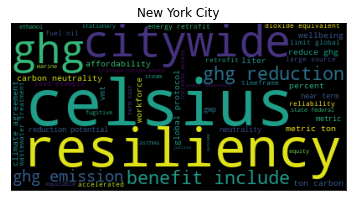

In [6]:
def plot_wordcloud(city, ax):
    top_terms = city_specific_keywords[city]
    tt = {row['term']: row['score'] for _, row in top_terms.head(50).iterrows()}
    wc = WordCloud().generate_from_frequencies(tt)
    ax.imshow(wc)
    ax.set_title(city)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig, ax = plt.subplots()
plot_wordcloud('New York City', ax=ax)

In [7]:
city_specific_keywords

{'Aalborg':                       term     score
 0     municipality climate  0.087644
 1                     tion  0.082601
 2         climate strategy  0.079876
 3           municipal plan  0.062358
 4             wind turbine  0.060482
 ...                    ...       ...
 2092                 fleet  0.006492
 2093                 reach  0.006450
 2094             available  0.006388
 2095                 value  0.006327
 2096                 group  0.005976
 
 [2097 rows x 2 columns],
 'Aarhus':                        term     score
 0              climate plan  0.112651
 1                    refuse  0.110825
 2                      tion  0.083235
 3     construction industry  0.080169
 4                  expected  0.077190
 ...                     ...       ...
 1254                  order  0.009477
 1255                account  0.009417
 1256                 policy  0.009357
 1257                vehicle  0.009210
 1258              implement  0.009181
 
 [1259 rows x 2 columns],

## Get all keywords

In [8]:
all_keywords = {'term': [], 'city': [], 'score': []}
for city in city_specific_keywords:
    city_terms = city_specific_keywords[city].reset_index()
    all_keywords['term'] += city_terms['term'].tolist()
    all_keywords['score'] += city_terms['score'].tolist()
    all_keywords['city'] += len(city_terms) * [city]
all_keywords = pd.DataFrame(all_keywords)
all_keywords

,term,city,score
0,municipality climate,Aalborg,0.087644
1,tion,Aalborg,0.082601
2,climate strategy,Aalborg,0.079876
3,municipal plan,Aalborg,0.062358
4,wind turbine,Aalborg,0.060482
...,...,...,...
630878,increase,Ærø,0.019544
630879,work,Ærø,0.019544
630880,public,Ærø,0.019178
630881,building,Ærø,0.018997


In [9]:
!mkdir factors

mkdir: factors: File exists


In [10]:
# json.dump(normalized_x2g.toarray().tolist(), open('factors/tfidf_vectors.json', 'w'))

In [11]:
keyword_set = list(set(all_keywords['term']))
len(keyword_set)

8093

## Use Word Vector similarity to construct lexicons for different emissions sources

In [12]:
import spacy
from tqdm.notebook import tqdm

nlp = spacy.load('en_core_web_md')

keyword_vec = [nlp(kw).vector for kw in tqdm(keyword_set)]

In [13]:
x_2g

<317x8093 sparse matrix of type '<class 'numpy.int64'>'
	with 630883 stored elements in Compressed Sparse Row format>

In [14]:
import numpy as np

keyword_vec = np.array(keyword_vec)
keyword_vec

array([[-0.39784   ,  0.26372   ,  0.91018   , ..., -0.11161   ,
         0.10489   ,  0.29398   ],
       [-0.08494499,  0.427418  ,  0.2957    , ..., -0.0342115 ,
         0.08121   ,  0.060215  ],
       [-0.16713   ,  0.17059499,  0.0395005 , ...,  0.02752   ,
         0.216285  , -0.13923651],
       ...,
       [ 0.22892   , -0.33213   ,  0.27936   , ..., -0.8549    ,
        -0.056927  , -0.045351  ],
       [-0.20727   , -0.37434   , -0.20286   , ..., -0.66223   ,
        -0.1791    , -0.20654   ],
       [-0.38629502,  0.70178   ,  0.17223498, ..., -0.25735   ,
         0.14367001, -0.0266935 ]], dtype=float32)

## Build Topic Keyterm dictionaries

Results from LSA and LDA based topic modelling methods weren't great, so let's build our own topics. Each topic will correspond to a lexicon of keyterms, and we define our topics based on major climate issues including:

* land use
* energy
* buildings
* transportation
* heating
* pollution
* climate impacts

### Manually constructing lexicons will be very time-consuming but if we're smart we can make it much faster. 

1. For each of these topics we will construct an initial lexicon of a few terms related to that topic
2. then use word vector similarity to find terms similar to these seed terms
3. choose the best ones that are most relevant to our topic
4. Add the best terms to our lexicon
5. Repeat steps 1-4 until satisfied with our lexicons.

### This way, we can manually curate the topic terms to make sure they're high quality, but have the word vector similarity recall similar terms for us, rather than having to think of them.

In [15]:
keyword_set

['kilowatt',
 'set energy',
 'expect year',
 'initiative european',
 'reform',
 'help meet',
 'centralized',
 'plan objective',
 'firm',
 'autumn',
 'year cost',
 'change impact',
 'high rate',
 'fuel natural',
 'factor',
 'intend',
 'upfront cost',
 'datum emission',
 'area building',
 'measure table',
 'action contribute',
 'note',
 'baseline emission',
 'continue provide',
 'sector source',
 'investigation',
 'promote good',
 'household energy',
 'gasoline diesel',
 'electricity year',
 'natural environment',
 'stop',
 'possible estimate',
 'active transportation',
 'area improve',
 'use air',
 'service provide',
 'forest management',
 'pound',
 'production photovoltaic',
 'global average',
 'waste emission',
 'coal power',
 'article',
 'energetic',
 'depict',
 'need increase',
 'performance building',
 'qualification',
 'emission waste',
 'uniform',
 'dairy',
 'factor affect',
 'action contain',
 'glazing',
 'potable water',
 'fund use',
 'biogas',
 'compare',
 'cycle',
 'transit o

In [16]:
keyword_vec

array([[-0.39784   ,  0.26372   ,  0.91018   , ..., -0.11161   ,
         0.10489   ,  0.29398   ],
       [-0.08494499,  0.427418  ,  0.2957    , ..., -0.0342115 ,
         0.08121   ,  0.060215  ],
       [-0.16713   ,  0.17059499,  0.0395005 , ...,  0.02752   ,
         0.216285  , -0.13923651],
       ...,
       [ 0.22892   , -0.33213   ,  0.27936   , ..., -0.8549    ,
        -0.056927  , -0.045351  ],
       [-0.20727   , -0.37434   , -0.20286   , ..., -0.66223   ,
        -0.1791    , -0.20654   ],
       [-0.38629502,  0.70178   ,  0.17223498, ..., -0.25735   ,
         0.14367001, -0.0266935 ]], dtype=float32)

In [17]:
inp_data

,Unnamed: 0,city_name,region,coordinator_name,doc_lengths,econ_wide_net_zero,AGGRESSIVE_TARGET,lemmatized_text
0,0,Aalborg,Europe,NaN,14292,True,True,climate strategy mitigation introduction the g...
1,1,Aarhus,Europe,NaN,6212,True,True,climate plan bid foreword the transformation f...
2,2,Aberdeenshire,Europe,"['Convention of Scottish Local Authorities, GB...",2492,True,False,aberdeen committee urgent business committee d...
3,3,Acquappesa,Europe,Energia Calabria Network,10817,True,True,calabria municipality action plan for sustaina...
4,4,Adelaide,East Asia and the Pacific,NaN,14968,True,False,carbon neutral action plan the state governmen...
...,...,...,...,...,...,...,...,...
312,320,Wezembeek-Oppem,Europe,Provincie Vlaams-Brabant,27191,True,True,call climate work integral the way environment...
313,321,Winnipeg,North America,NaN,51659,True,False,climate action plan plan for climate change ac...
314,322,Wollongong,East Asia and the Pacific,NaN,14905,False,False,draft climate change mitigation plan acknowled...
315,323,Wyndham,East Asia and the Pacific,NaN,4477,True,True,greenhouse action plan greenhouse action plan ...


In [18]:
keyword_vec.shape

topics = [
    'natural disaster'
]

topic_vecs = np.array([nlp.vocab.get_vector(term) for term in topics])
topic_vecs.shape

(1, 300)

In [19]:
len(keyword_set)

8093

## Use word vector cosine similarity to search for similar terms

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

sims = cosine_similarity(topic_vecs, keyword_vec)
sims.shape

(1, 8093)

In [21]:
SHOW = 200

for idx, topic in enumerate(topics):
    kw_sims = sims[idx, :]
    similar_kws = [keyword_set[idx] for idx, sim in 
                   sorted(enumerate(kw_sims),key=lambda p: p[1], reverse=True)][:SHOW]
    print('\n\n\n\n\n')
    print(topic)
    print(similar_kws)







natural disaster
['kilowatt', 'set energy', 'expect year', 'initiative european', 'reform', 'help meet', 'centralized', 'plan objective', 'firm', 'autumn', 'year cost', 'change impact', 'high rate', 'fuel natural', 'factor', 'intend', 'upfront cost', 'datum emission', 'area building', 'measure table', 'action contribute', 'note', 'baseline emission', 'continue provide', 'sector source', 'investigation', 'promote good', 'household energy', 'gasoline diesel', 'electricity year', 'natural environment', 'stop', 'possible estimate', 'active transportation', 'area improve', 'use air', 'service provide', 'forest management', 'pound', 'production photovoltaic', 'global average', 'waste emission', 'coal power', 'article', 'energetic', 'depict', 'need increase', 'performance building', 'qualification', 'emission waste', 'uniform', 'dairy', 'factor affect', 'action contain', 'glazing', 'potable water', 'fund use', 'biogas', 'compare', 'cycle', 'transit orient', 'payment', 'illuminate', 'cam

In [22]:
keyword_series = pd.Series(keyword_set)
keyword_series[keyword_series.str.lower().str.contains('emission')].tolist()

['datum emission',
 'baseline emission',
 'waste emission',
 'emission waste',
 'emission municipal',
 'emission improve',
 'achieve emission',
 'emission capita',
 'emission reference',
 'emission inventory',
 'emission plan',
 'emission saving',
 'estimate emission',
 'emission datum',
 'responsible emission',
 'emission support',
 'emission reduce',
 'emission start',
 'emission strategy',
 'emission make',
 'local emission',
 'emission key',
 'emission sector',
 'standard emission',
 'emission zero',
 'emission avoid',
 'emission million',
 'european emission',
 'equal emission',
 'emission scenario',
 'level emission',
 'emission monitor',
 'total emissions',
 'emissions inventory',
 'scenario emission',
 'compare emission',
 'overall emission',
 'emission sustainable',
 'emission ton',
 'term emission',
 'factor emission',
 'emissions reduction',
 'emission air',
 'community emission',
 'emission factor',
 'emission car',
 'emission create',
 'emission carrier',
 'production emis

## Initialize topics with seed terms in this dictionary

In [23]:
topic_terms = {
    'land use': [
        'agriculture', 'irrigation', 'agricultural', 'farming', 'farmers', 'livestock', 
        'farmland', 'farm', 'orchard', 'permaculture', 'rural', 'crop', 'dairy', 
        'fisheries', 'farmer', 'grower', 'landowner', 'cattle', 'erosion', 'runoff', 'soil', 
        'sediment', 'fertilizer', 'manure', 'aquaponic', 'land', 'commodity', 'drought', 
        'plants', 'hydroponic', 'harvesting', 'harvest',
        'food', 'organics', 'organic', 'pruning', 'planting', 
        'landscapes', 'landscape', 'plant', 'vegetable',
        'fertilizer', 'manure', 'acre', 'acreage', 'hectare',
        'forestry', 'land', 'environmentally', 'greening', 'livable', 'liveable', 
        'biodiversity', 'stewardship', 'conservancy', 'reforestation', 
        'conservation', 'deforestation', 'ozone', 'biodiverse', 
        'estuary', 'woodland', 'forest', 'riparian', 'prairie', 'floodplain', 
        'wetlands', 'grassland', 'wetland', 'ecosystem', 'ecosystems', 
        'hydrological', 'greening', 'fauna', 'wildlife', 
        'vegetation', 'habitat' ,'pollinator', 'preservation', 'ecological', 'forestry', 'woodland', 'forest', 
         'ecosystem', 'ecosystems', 'hydrological', 'species', 'specie', 'biodiverse', 
        'reclamation', 'restoration', 'marine', 'parks', 'greenspace', 'ozone', 'nature', 
        'animal', 'extinction', 'botanical', 'parkland', 'gardens', 'bird',
        'desert', 'trees', 'sea', 'basin', 'waterway', 'river', 
       'ocean', 'marsh', 'garden', 'gardening', 'ecologically', 'grain',
        'pesticide', 'waters', 'regenerative', 'creek', 'fruit', 'pest',
        'grass', 'regeneration', 'gardening', 'tree', 'lake', 'pond',
        'aquatic', 'wild', 'fish', 'oceanic', 'insect', 'nutrient', 
        'fishing', 'hillside', 'shore', 'shoreline', 'gravel', 'seed', 'weed',
        'habitat', 'parks', 'parks', 'parcel'

    ],
    'offsets': [
        'offsets',
        'offset',
        'offset purchase',
        'emission offset',
        'offset carbon',
        'carbon offset',
        'negative emission',
        'carbon credit', 
        'carbon capture',
        'absorb carbon',
        'carbon sink',
        'remove carbon',
        'sequester',
        'carbon sequester',
        'sequestration',
        'carbon sequestration',
        'sequester carbon',
        'soil carbon',
        'carbon credits',
        'offset emission'
    ],
    'transportation': [
       'transportation', 'transit', 'transport', 'rail', 'driverless', 
        'highways', 'intercity', 'streetcar', 'rideshare', 'ridesharing', 
        'ridership', 'carsharing', 'vanpool', 'commuter', 'airport', 'travel', 
        'vehicles', 'passenger', 'occupant', 'commuting', 'telecommuting', 
        'tram', 'bus', 'railway', 'railroad', 'highway', 'roadway', 
        'taxis', 'minibus', 'taxi', 'roads', 'parking', 'train', 'vehicle', 
        'routes', 'bicycle', 'commute', 'carpool', 'ferry', 'trucks', 
        'driving', 'cars', 'mileage', 'mpg', 'engine', 'exhaust', 'tailpipe',
        'motor', 'cars', 'metro', 'bike', 'gasoline', 'gas','diesel', 'petrol', 'petroleum', 'oil',
        'shuttle', 'flight', 'walking', 'trip', 'aviation', 'motorist', 'truck', 'motorcycle', 
        'station', 'wheel', 'subway', 'bikeway', 'journeys', 'driver', 
        'bicycling', 'street', 'destination', 'cyclist', 'car', 'journey', 'vehicular', 
        'walk', 'bikeshare', 'automobile', 'route', 'hauler', 'scooter', 'pedestrian', 
        'bicyclist', 'cycling', 'biking', 'downtown', 'auto', 'gear', 'traffic', 'rooftop', 'drive', 
        'carpooling', 'rider', 'road', 'ride', 'lane', 'corridor', 'walkway', 'sidewalk', 
        'ramp', 'tire', 'driveway', 'mile', 'haul', 'parking', 'freight', 'logistics'
    ],
    'heating': [
        'btu', 'heater', 'thermostat', 'therm', 'heaters', 'gallon', 'heating', 'boiler',
        'cooling', 'heating', 'boiler', 'heat', 'temperature', 'thermal', 'btu', 
        'heater', 'thermostat', 'therm', 'heaters', 'ventilation', 'snowpack', 
        'overheat', 'furnace', 'hvac', 'insulation', 'insulate', 'flow', 
        'steam', 'melt', 'circulation', 'cool', 'refrigeration', 'stove', 
        'dryer', 'air', 'electrical', 'conditioning', 'conditioner', 'refrigerator', 
        'refrigerant', 'blower'
    ],
    'energy': [
        'hydrogen', 'hydrocarbon', 'megawatt', 'electrification', 'hydro', 'kwh', 
        'electricity', 'kilowatt', 'vehicles', 'energy', 'megawatt', 
        'electrification', 'hydro', 'kwh', 'electricity', 'kilowatt', 'cogeneration', 
        'biomass', 'renewable', 'hydropower', 'renewables', 'bioenergy', 'geothermal', 
        'biogas', 'power', 'photovoltaic', 'solar', 'fuels', 'fuel', 'electric', 
        'wind', 'turbine','hydrocarbon', 'coal', 'refinery', 'radiation', 
        'biodiesel', 'feedstock', 'ethanol', 'biofuel', 'fuel', 'kerosene',  
        'propane', 'fuels', 'nuclear',
         'combustion', 'emission',  'biodiesel', 'feedstock', 
         'ethanol', 'biofuel' , 'energy', 
         'glazing', 'combust', 'hybrid', 
        'charging', 'battery', 'lpg', 'fossil','powered', 'grid',
         'efficiency', 'utilization', 'supply', 'generating', 
        'efficient', 'generate', 'generator', 'generation', 
        'pipeline', 'sunlight', 'fluctuation', 'surge'
    ],
    'pollution/waste':[
        'incinerator', 'waste', 'landfills', 'landfill', 'incineration', 'effluent', 
        'sludge', 'disposal', 'dispose', 'recycling', 'composting', 'garbage', 'trash', 
        'recycle', 'dumping', 'recyclable', 'compostable', 'recycled', 'biodegradable', 
        'scrap', 'pollution', 'polluted', 'polluting', 'smog', 'polluted', 'pollutant',
        'compost', 'toxic', 'methane', 'hazardous', 'contaminated', 'contaminant', 'contaminate', 
        'contamination', 'litter', 'dump', 'sewage', 'sewer', 'wastewater', 
        'stormwater', 'plastic', 'cleaning', 'sulfur'
    ],
    'building': [
        'interior', 'build', 'plumbing', 'refurbishment', 'house', 'wall', 'tower', 
        'floor', 'substation', 'homes', 'architectural', 'architecture', 
        'facility', 'lighting', 'reconstruction',  'residence', 'work', 
        'home', 'dwelling', 'architect', 'architects', 'retrofit', 'retrofits', 
        'construction', 'demolition', 'renovation', 'building', 'concrete', 
        'paving', 'infill', 'buildings', 'structural', 'design', 'subcontractor', 
        'contractor', 'residential', 'multifamily', 'nonresidential', 'maintenance', 
        'structure', 'construct', 'builders', 'built', 'facade', 'exterior', 
        'bridge', 'shingle', 'roofs', 'roofing', 'roof', 'housing', 
        'development', 'durable', 'builder', 'installation', 'permitting', 
        'developments' 
    ],
    'climate impacts': [
        'flooding', 'inundation', 'levee', 'flood', 'inundate', 'downpour', 
        'rainstorm', 'rainfall', 'storm', 'heatwave', 'drought', 'katrina', 
        'hurricane', 'rain', 'preparedness', 'disaster', 'seismic', 'tributary', 
        'watershed', 'watercourse', 'catchment', 'earthquake', 'devastating', 
        'severe', 'tornado', 'basin', 'impacts', 'debris', 'drainage', 'rainwater', 
        'influx', 'groundwater', 'hazard', 'wildfire', 'burning','crisis', 'climatic', 
        'survive', 'evacuation', 'shelter', 'destructive',
        'catastrophic', 'potable', 'weather', 'forecast', 'destruction', 'damage', 'threat', 
        'damaging', 'dangerous', 'vulnerable', 'threaten', 'endanger', 'risk', 'harm', 
    ],
    'industry': [
        'industrial', 'industries', 'machinery', 
        'industry', 'additive', 'chemical', 
        'mining', 'mechanical', 'factory', 
        'steel', 'metal', 
        'materials', 
        'incinerator', 'freight', 'tonnage', 'intermodal', 
        'manufacture', 'operations', 'warehouse', 'goods', 
        'bulk', 'heavy', 'packaging', 'manufacturer', 'facilities', 'inspector', 'inspection', 
        'manufacturing', 'supply chain'
    ]

} 

In [24]:
from pprint import pprint

pprint(topic_terms)

{'building': ['interior',
              'build',
              'plumbing',
              'refurbishment',
              'house',
              'wall',
              'tower',
              'floor',
              'substation',
              'homes',
              'architectural',
              'architecture',
              'facility',
              'lighting',
              'reconstruction',
              'residence',
              'work',
              'home',
              'dwelling',
              'architect',
              'architects',
              'retrofit',
              'retrofits',
              'construction',
              'demolition',
              'renovation',
              'building',
              'concrete',
              'paving',
              'infill',
              'buildings',
              'structural',
              'design',
              'subcontractor',
              'contractor',
              'residential',
              'multifamily',
              'nonre

In [25]:
all_topic_terms = [term for topic in topic_terms for term in topic_terms[topic]]

In [26]:
tfidf_sums = np.squeeze(np.asarray(normalized_x2g.sum(axis=0)))
tfidf_sums

array([1.51714036, 0.6545794 , 1.25499549, ..., 1.94855982, 3.28369403,
       1.73448091])

## For each topic's terms, identify most similar terms, and add the best ones to your seed dictionary above.

In [27]:
topic_term_vecs = dict()
THRESH = 0.3
INCLUDE_2GRAMS = True

for topic in topic_terms:
    print('\n\n\nTOPIC:{}'.format(topic))
    term_vecs = np.array([nlp(term).vector for term in topic_terms[topic]])
    sims = cosine_similarity(term_vecs, keyword_vec)
    kw_sims = list(sims.mean(axis=0))
        
    relevant = list(sorted(
            enumerate(kw_sims),key=lambda p: p[1], 
        reverse=True))
    
    relevant = sorted([
        (keyword_set[idx], tfidf_sums[idx]) for idx, sim in relevant
        if keyword_set[idx] not in all_topic_terms and sim > THRESH
    ], key=lambda p: p[1], reverse=True)
    relevant = [r[0] for r in relevant][:100]
        
    print(relevant)




TOPIC:land use
['treatment plant', 'water management', 'increase climate', 'objective energy', 'water conservation', 'area provide', 'efficiency building', 'emission measure', 'local energy', 'transportation sector', 'consume municipal', 'transportation demand', 'quality life', 'plant production', 'regional level', 'climate policy', 'transport consumption', 'green building', 'population density', 'electricity market', 'waste landfill', 'reduce carbon', 'municipal buildings', 'summit', 'risk flooding', 'biomass energy', 'year renewable', 'transport industry', 'regional development', 'green area', 'practice energy', 'structure municipality', 'sustainable urban', 'specific area', 'agriculture forestry', 'use community', 'vulnerable population', 'year municipality', 'energy supply', 'saving electricity', 'create local', 'government building', 'energy reduction', 'health environment', 'potential use', 'community garden', 'consumption sector', 'energy development', 'government develop', '

['treatment plant', 'water management', 'energy consumer', 'increase climate', 'objective energy', 'water conservation', 'saving action', 'efficiency building', 'emission measure', 'local energy', 'consumption increase', 'efficiency production', 'transportation sector', 'consume municipal', 'use thermal', 'inadequate', 'transportation demand', 'residential non', 'plant production', 'reduce cost', 'carbon content', 'transport consumption', 'green building', 'vehicle emission', 'energy solution', 'make necessary', 'electricity market', 'waste landfill', 'reduce carbon', 'municipal buildings', 'risk flooding', 'objective reduce', 'biomass energy', 'year renewable', 'transport industry', 'kwh kwh', 'green area', 'gas heating', 'practice energy', 'structure municipality', 'mitigate', 'saving measure', 'sustainable urban', 'low consumption', 'agriculture forestry', 'efficient appliance', 'year municipality', 'energy supply', 'saving electricity', 'government building', 'energy reduction', 'd

In [28]:
topics = list(topic_terms.keys())
topics

['land use',
 'offsets',
 'transportation',
 'heating',
 'energy',
 'pollution/waste',
 'building',
 'climate impacts',
 'industry']

In [29]:
for topic in topic_terms:
    topic_terms[topic] = [term for term in topic_terms[topic] if term in cv_2grams_vocabulary_]
topic_terms

{'land use': ['agriculture',
  'irrigation',
  'agricultural',
  'farming',
  'livestock',
  'farm',
  'rural',
  'crop',
  'dairy',
  'farmer',
  'cattle',
  'erosion',
  'runoff',
  'soil',
  'fertilizer',
  'manure',
  'land',
  'commodity',
  'drought',
  'plants',
  'harvesting',
  'harvest',
  'food',
  'organic',
  'planting',
  'landscape',
  'plant',
  'vegetable',
  'fertilizer',
  'manure',
  'acre',
  'hectare',
  'forestry',
  'land',
  'environmentally',
  'greening',
  'livable',
  'biodiversity',
  'stewardship',
  'reforestation',
  'conservation',
  'ozone',
  'forest',
  'wetland',
  'ecosystem',
  'greening',
  'wildlife',
  'vegetation',
  'habitat',
  'preservation',
  'ecological',
  'forestry',
  'forest',
  'ecosystem',
  'species',
  'specie',
  'reclamation',
  'restoration',
  'marine',
  'parks',
  'ozone',
  'nature',
  'animal',
  'gardens',
  'bird',
  'sea',
  'basin',
  'waterway',
  'river',
  'ocean',
  'garden',
  'gardening',
  'ecologically',
  'p

In [30]:
json.dump(topic_terms, open('factors/topic_term_dict.json', 'w'))

In [31]:
Ys = ['HAS_TARGET']

In [32]:
doc_lengths = inp_data['doc_lengths']

## Build topic vector representations

In [33]:
independent = dict()

for representation in ['count', 'tfidf']:
    independent[representation] = dict()
    for postprocess in [None, 'divide_by_doclength']:
        independent[representation][postprocess] = dict()
        for standardize in [False, True]:
            for ngram_range in [1, 2]:
                all_feats = []
                for topic in topics:
                    if representation == 'count':
                        if ngram_range == 1:
                            feats = x.toarray()
                        else:
                            feats = x_2g.toarray()
                    else:
                        if ngram_range == 1:
                            feats = normalized_x.toarray()
                        else:
                            feats = normalized_x2g.toarray()
                    terms = list(set(topic_terms[topic]))
                    
                    if ngram_range == 1:
                        feats = feats[:, [cv_vocabulary_[t] for t in terms if len(t.split(' ')) == 1]].sum(axis=1)
                    else:
                        feats = feats[:, [cv_2grams_vocabulary_[t] for t in terms]].sum(axis=1)
                    assert feats.shape[0] == inp_data.shape[0]
                    if postprocess == 'divide_by_doclength':
                        feats = feats / doc_lengths
                    if standardize:
                        feats = (feats - feats.mean()) / feats.std()
                    # OLS
                    all_feats.append(feats)
                    
                all_feats = np.array(all_feats).T
                independent[representation][postprocess][standardize] = all_feats

In [34]:
independent['count'][None][False].shape

(317, 9)

In [35]:
import seaborn as sns

X = pd.DataFrame(independent['count'][None][False], columns=topics)
X

,land use,offsets,transportation,heating,energy,pollution/waste,building,climate impacts,industry
0,203,0,584,287,1219,34,303,13,32
1,24,0,143,58,354,21,147,5,49
2,3,0,35,6,69,1,27,18,7
3,42,1,120,62,707,9,224,3,15
4,99,97,535,43,1040,196,393,7,54
...,...,...,...,...,...,...,...,...,...
312,521,3,401,182,735,31,836,27,21
313,581,17,2354,178,1715,876,1630,109,129
314,254,14,393,52,777,263,409,38,47
315,46,40,83,10,326,20,115,18,13


In [36]:
X

,land use,offsets,transportation,heating,energy,pollution/waste,building,climate impacts,industry
0,203,0,584,287,1219,34,303,13,32
1,24,0,143,58,354,21,147,5,49
2,3,0,35,6,69,1,27,18,7
3,42,1,120,62,707,9,224,3,15
4,99,97,535,43,1040,196,393,7,54
...,...,...,...,...,...,...,...,...,...
312,521,3,401,182,735,31,836,27,21
313,581,17,2354,178,1715,876,1630,109,129
314,254,14,393,52,777,263,409,38,47
315,46,40,83,10,326,20,115,18,13


<AxesSubplot:>

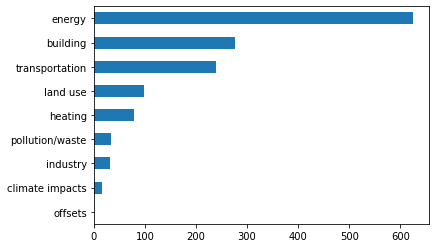

In [37]:
topic_counts = X.aggregate('median').sort_values()
topic_counts.plot.barh()

In [38]:
topic_counts.to_csv('topic_counts.csv')

##

## Analysis of Emissions Source topics 
### PCA

<AxesSubplot:>

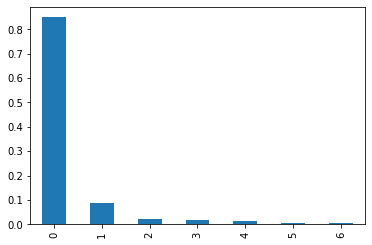

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=7)
components = pca.fit_transform(X)
pd.Series(pca.explained_variance_ratio_).plot.bar()

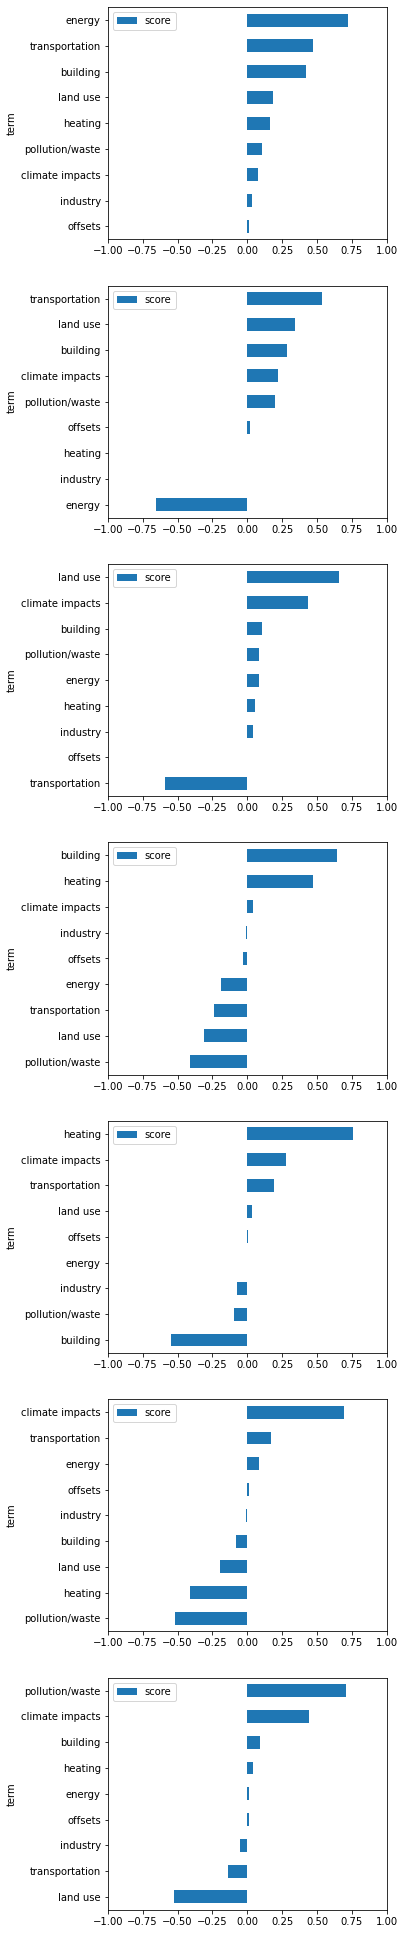

In [40]:
def show_topic_words(terms, components):
    num_topics = len(components)
    fig, axes = plt.subplots(nrows=num_topics, figsize=(5, num_topics * 5))
    for i, (comp, ax) in enumerate(zip(components, axes)):
        terms_comp = zip(terms, comp)
        sorted_terms = reversed(list(sorted(terms_comp, key= lambda x:x[1], reverse=True)[:20]))
        sorted_terms = pd.DataFrame(sorted_terms, columns=['term', 'score']).set_index('term')
        sorted_terms.plot.barh(y='score', ax=ax, xlim=(-1,1))
        
show_topic_words(X.columns, pca.components_)

In [41]:
components.shape

(317, 7)

### Factor analysis

In [42]:
X = pd.DataFrame(independent['tfidf'][None][True], columns=topics)
X

,land use,offsets,transportation,heating,energy,pollution/waste,building,climate impacts,industry
0,0.467298,-0.643687,1.471938,0.549165,1.094961,-0.358333,0.360758,-0.242274,0.842363
1,-0.767808,-0.643687,-0.177258,-0.790482,0.624430,0.091595,-0.687960,-0.726087,0.064846
2,-1.219481,-0.643687,-0.535410,-1.125396,-1.011046,-1.211881,-1.742723,0.048814,-0.393524
3,-0.858785,-0.415347,-0.891208,-0.402216,0.649451,-1.006191,0.091806,-0.798394,-1.166072
4,0.029802,3.733667,1.065582,0.073115,1.316914,0.730397,0.107019,-0.629023,1.455470
...,...,...,...,...,...,...,...,...,...
312,1.443645,-0.043769,0.273563,1.005953,0.427150,-0.611729,1.213278,0.078659,-0.614441
313,0.953825,0.432057,2.187422,0.212653,-0.322546,2.272986,1.119790,0.616711,1.993950
314,1.004781,1.532147,0.478887,-0.027898,-0.135505,1.165841,0.266316,0.816840,0.804707
315,0.264877,2.753024,-0.478595,-1.280549,0.902655,-0.255346,0.239629,0.342308,0.302883


In [43]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(X)
chi_square_value, p_value

(1325.232641282506, 2.1814537115057993e-255)

In [44]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(X)
kmo_model

0.7876178027513705

<AxesSubplot:title={'center':'Factor Analysis Eigenvalue Plot'}>

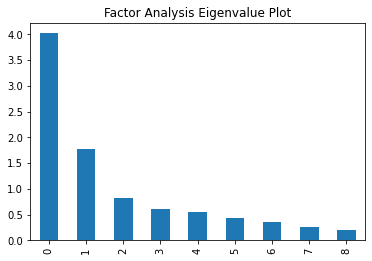

In [45]:
from factor_analyzer.factor_analyzer import FactorAnalyzer

# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(25, rotation=None)
fa.fit(X)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev = pd.Series(ev)
ev.plot.bar(title='Factor Analysis Eigenvalue Plot')

In [46]:
ev / ev.sum()

0    0.446591
1    0.197058
2    0.091094
3    0.066909
4    0.061523
5    0.047286
6    0.039499
7    0.027936
8    0.022104
dtype: float64

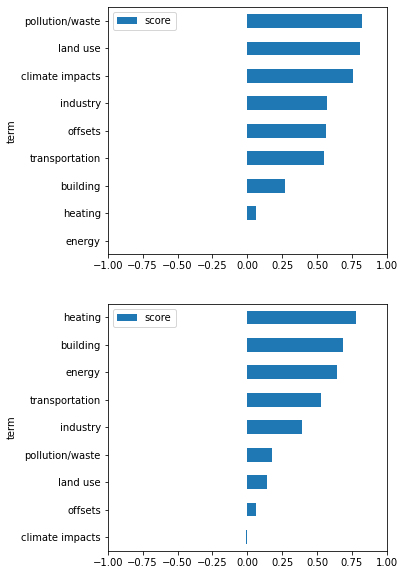

In [47]:
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(X)
show_topic_words(X.columns, fa.loadings_.T)

In [48]:
# json.dump(X.set_index(inp_data.city_name).to_dict(), open('factors/topic_vectors.json', 'w'))

In [49]:
# json.dump(X.to_dict(), open('factors/topic_vectors_by_cit')

In [50]:
# json.dump(fa.loadings_.tolist(), open('factors/loadings.json', 'w'))

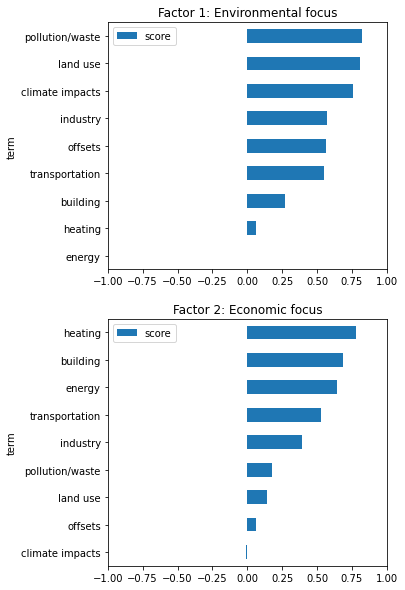

In [51]:
def show_topic_words(terms, components, titles):
    num_topics = len(components)
    fig, axes = plt.subplots(nrows=num_topics, figsize=(5, num_topics * 5))
    for i, (comp, ax, title) in enumerate(zip(components, axes, titles)):
        terms_comp = zip(terms, comp)
        sorted_terms = reversed(list(sorted(terms_comp, key= lambda x:x[1], reverse=True)[:20]))
        sorted_terms = pd.DataFrame(sorted_terms, columns=['term', 'score']).set_index('term')
        sorted_terms.plot.barh(y='score', ax=ax, xlim=(-1,1))
        ax.set_title(title)
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(X)
show_topic_words(X.columns, fa.loadings_.T, ['Factor 1: Environmental focus', 'Factor 2: Economic focus'])

In [52]:
pd.DataFrame(fa.loadings_, index=X.columns, columns = ['Factor 1: Economic focus', 'Factor 2: Environmental focus']).to_csv('factor_loadings.csv')

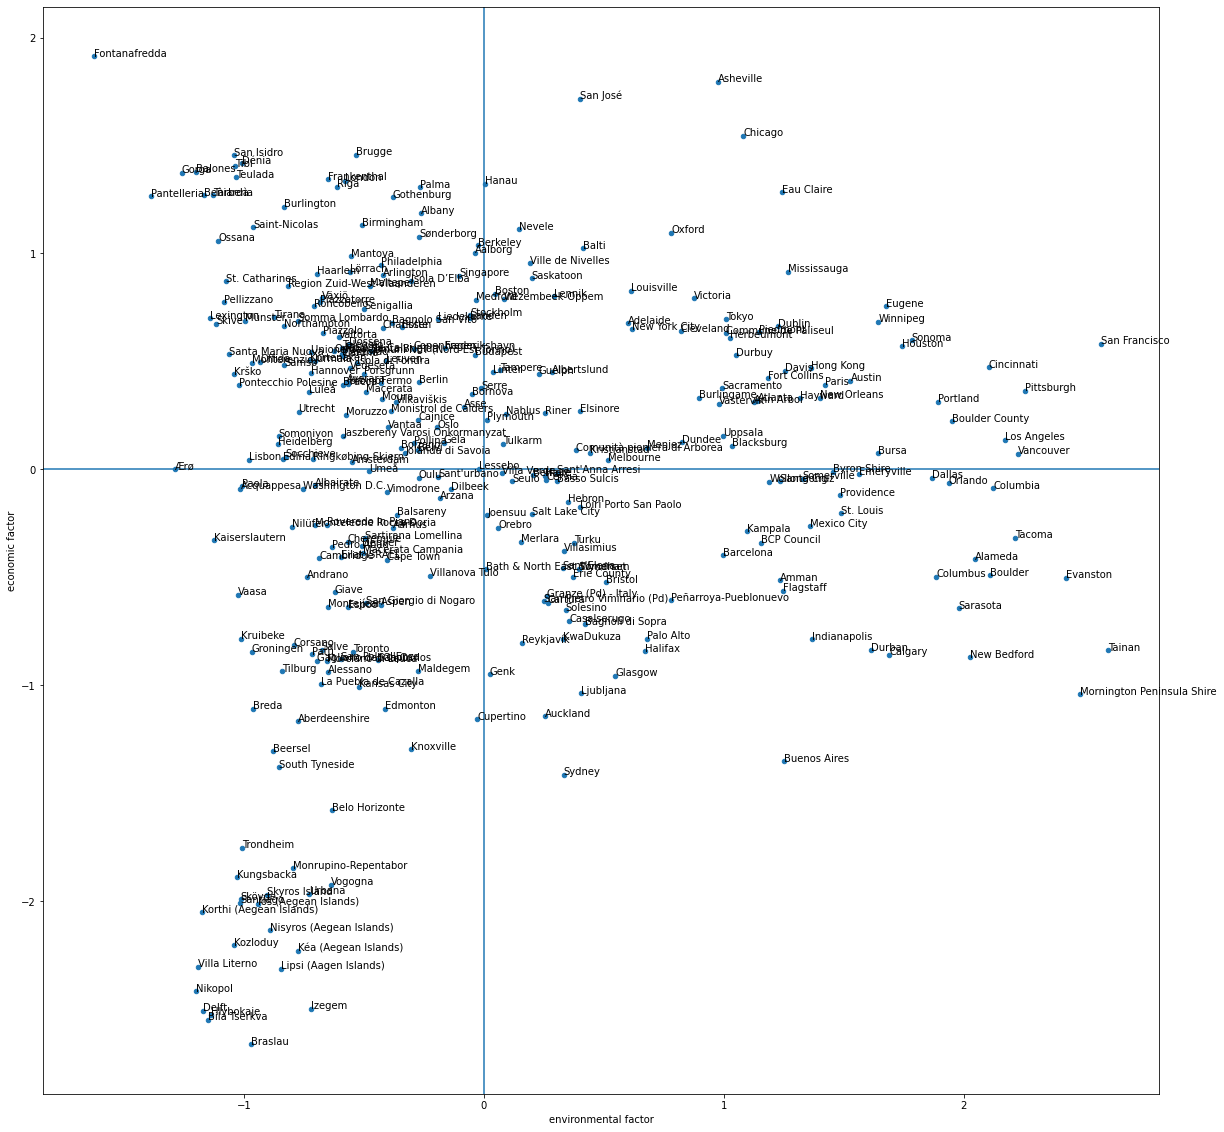

In [53]:
fv = pd.DataFrame(fa.transform(X), columns=['environmental factor', 'economic factor']).set_index(inp_data.city_name)
# fv['region'] = inp_data['region']

fig, ax = plt.subplots(figsize=(20,20))
fv.plot.scatter(x='environmental factor', y='economic factor', ax=ax)
for i, city in enumerate(fv.index):
    ax.annotate(city, (fv['environmental factor'][i], fv['economic factor'][i]), size=10)
    
ax.axvline(0)
ax.axhline(0)

In [54]:
# json.dump(fv.to_dict(), open('factors/city_factor_scores.json', 'w'))

In [55]:
fv.median()

environmental factor   -0.290029
economic factor         0.115890
dtype: float64

In [56]:
pd.DataFrame(fa.get_factor_variance(), index=['SS Loadings', 'Proportional Variance', 'Cumulative Variance'])

,0,1
SS Loadings,2.924665,1.987116
Proportional Variance,0.324963,0.220791
Cumulative Variance,0.324963,0.545753


## filtered terms

<AxesSubplot:>

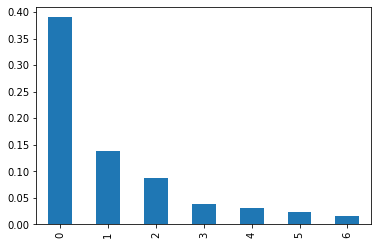

In [57]:
all_topic_terms =  [term for topic in topic_terms for term in topic_terms[topic]]
topic_word_idxs = [cv_2grams_vocabulary_[term] for term in all_topic_terms]
filtered_x = x_2g[:, topic_word_idxs]
components = pca.fit_transform(x_2g.A)
pd.Series(pca.explained_variance_ratio_).plot.bar()

<AxesSubplot:>

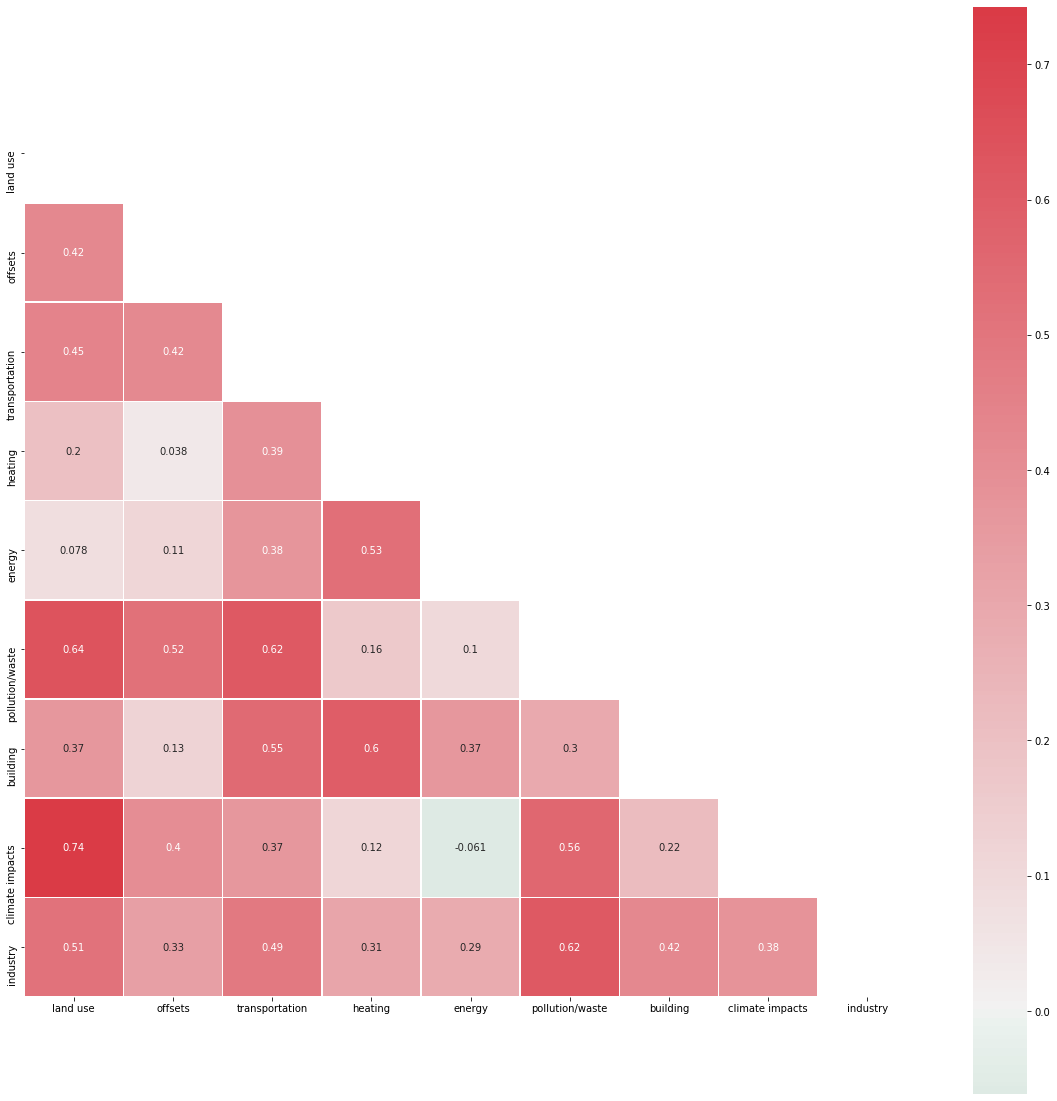

In [58]:
corr = X.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(150, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, annot=True)
            #cbar_kws={"shrink": .5});